I'm running a few sets of chains that are fitting the redMagic HOD to a shuffled SHAM, as well as SHAMs with assembly bias to see what happens. I want all the tests I want to do to be in one place. This notebook will do the following:
* Load the chain and plot the contours
* Calculate the MAP values
* Load the original HOD and clustering for the SHAM sample of interest. 
* Populate the halo catalog and calculate its clustering.
* Plot the best fit clustering against the clustering in the fit
* Plot the best fit HOD to the true HOD of the sample

In [14]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [15]:
import numpy as np
from chainconsumer import ChainConsumer

ERROR! Session/line number was not unique in database. History logging moved to new session 289


In [16]:
from astropy.table import Table
from halotools.utils.table_utils import compute_conditional_percentiles
from halotools.mock_observables import hod_from_mock, wp, tpcf
from pearce.mocks import cat_dict
from pearce.mocks.customHODModels import *
from math import ceil

In [17]:
#fname = '/u/ki/swmclau2/des/PearceMCMC/100_walkers_1000_steps_chain_shuffled_sham_3.npy'
fname = '/u/ki/swmclau2/des/PearceMCMC/200_walkers_5000_steps_chain_shuffled_sham2.npy'
#fname = '/u/ki/swmclau2/des/PearceMCMC/200_walkers_5000_steps_chain_vpeak_sham_no_ab.npy'
#fname = '/u/ki/swmclau2/des/PearceMCMC/200_walkers_5000_steps_chain_vpeak_sham_no_ab_2.npy'
#fname = '/u/ki/swmclau2/des/PearceMCMC/200_walkers_5000_steps_chain_vpeak_sham_fscab.npy'

In [18]:
chain = np.loadtxt(fname )

In [19]:
chain.shape

(556800, 5)

In [25]:
n_walkers = 200
n_burn = 500
n_params = chain.shape[1]

In [26]:
chain = chain[n_burn*n_walkers:, :]

In [27]:
chain.shape

(206800, 5)

In [28]:
param_names = [r'$\log{M_{min}}$', r'$\log{M_0}$',r'$\sigma_{log{M}}$', r'$\log{M_1}$', r'$\alpha$']
#param_names = [r'$\log{M_{min}}$',r'$\mathcal{A}_{cen}$', r'$\log{M_0}$',r'$\sigma_{log{M}}$',\
#               r'$\mathcal{B}_{sat}$', r'$f_{cen}$', r'$f_{sat}$',r'$\mathcal{A}_{sat}$', \
#               r'$\mathcal{B}_{cen}$', r'$\log{M_1}$', r'$\alpha$']
#param_names = [r'$f_{sat}$',r'$\mathcal{A}_{sat}$',r'$f_{cen}$', r'$\mathcal{A}_{cen}$']
#param_names = [r'$\mathcal{A}_{sat}$',r'$\mathcal{A}_{cen}$']

In [29]:
c = ChainConsumer()
c.add_chain(chain, parameters=param_names, walkers=n_walkers)
c.configure(statistics='max')

In [30]:
gelman_rubin_converged = c.diagnostic.gelman_rubin()
print gelman_rubin_converged

Gelman-Rubin Statistic values for chain 0
$\log{M_{min}}$: 1.00162 (Passed)
$\log{M_0}$: 1.00103 (Passed)
$\sigma_{log{M}}$: 1.00170 (Passed)
$\log{M_1}$: 1.00133 (Passed)
$\alpha$: 1.00181 (Passed)
True


In [31]:
best_fit_vals = np.array([ 12.87364502,  12.23898854,0.53433088, 13.97462748,  1.04479171])

/u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


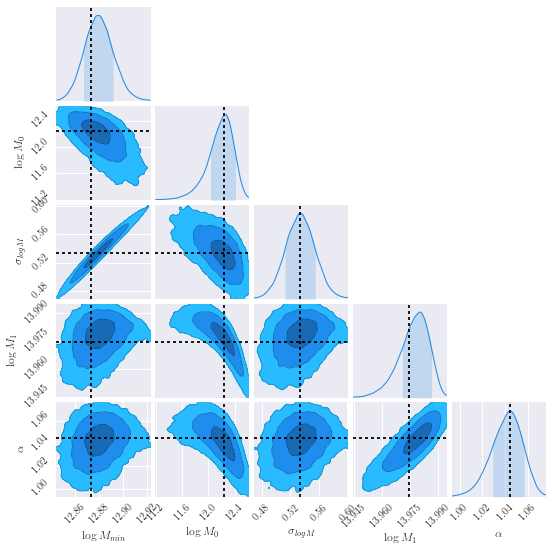

In [32]:
fig = c.plotter.plot(figsize=(8,8), parameters=param_names, truth = best_fit_vals)
fig.show()

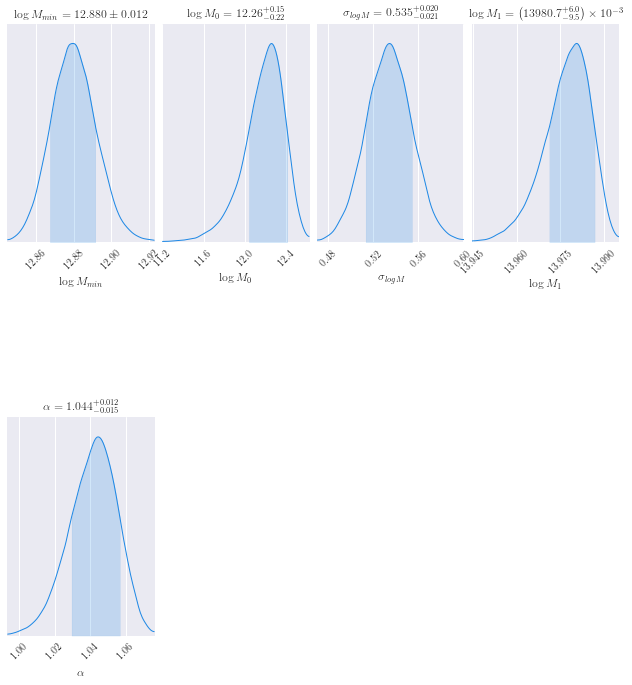

In [33]:
fig = c.plotter.plot_distributions(figsize=(10,10) )
fig.show()

In [34]:
summary  = c.analysis.get_summary()
MAP = np.array([summary[p][1] for p in param_names])
print MAP

[ 12.879553    12.25786857   0.53473759  13.98072338   1.04423883]


In [35]:
print param_names

['$\\log{M_{min}}$', '$\\log{M_0}$', '$\\sigma_{log{M}}$', '$\\log{M_1}$', '$\\alpha$']


In [36]:
PMASS = 591421440.0000001 #chinchilla 400/ 2048

halo_catalog = Table.read('/u/ki/swmclau2/des/AB_tests/abmatched_halos.hdf5', format = 'hdf5')

In [37]:
shuffle_type = 'sh_shuffled'
mag_type = 'vpeak'
mag_key = 'halo_%s_mag'%(mag_type)
upid_key = 'halo_upid'

#mag_key = 'halo%s_%s_mag'%(shuffle_type, mag_type)
#upid_key = 'halo%s_upid'%shuffle_type

In [38]:
cosmo_params = {'simname':'chinchilla', 'Lbox':400.0, 'scale_factors':[0.658, 1.0]}
cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!

cat.load_catalog(1.0)
#cat.h = 1.0

In [39]:
mag_cut = -21
min_ptcl = 200

halo_catalog = halo_catalog[halo_catalog['halo_mvir'] > min_ptcl*cat.pmass] #mass cut
galaxy_catalog = halo_catalog[ halo_catalog[mag_key] < mag_cut ] # mag cut

In [40]:
def compute_mass_bins(prim_haloprop, dlog10_prim_haloprop=0.1):   
    lg10_min_prim_haloprop = np.log10(np.min(prim_haloprop))-0.001
    lg10_max_prim_haloprop = np.log10(np.max(prim_haloprop))+0.001
    num_prim_haloprop_bins = (lg10_max_prim_haloprop-lg10_min_prim_haloprop)/dlog10_prim_haloprop
    return np.logspace(
        lg10_min_prim_haloprop, lg10_max_prim_haloprop,
        num=int(ceil(num_prim_haloprop_bins)))

In [41]:
mass_bins = compute_mass_bins(halo_catalog['halo_mvir'], 0.2)
mass_bin_centers = (mass_bins[1:]+mass_bins[:-1])/2.0
#mass_bin_centers = 10**((np.log10(mass_bins[1:])+np.log10(mass_bins[:-1]))/2.0)

In [42]:
cen_mask = galaxy_catalog['halo_upid']==-1
mass_key = 'halo_mvir_host_halo'#
#mass_key = 'halo_%s_host_mvir'%shuffle_type
cen_hod_sham, _ = hod_from_mock(galaxy_catalog[cen_mask][mass_key],\
                        halo_catalog['halo_mvir'],\
                        mass_bins)

sat_hod_sham, _ = hod_from_mock(galaxy_catalog[~cen_mask][mass_key],\
                        halo_catalog['halo_mvir'],\
                        mass_bins)

In [43]:
np.savetxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/cen_hod.npy', cen_hod_sham)
np.savetxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/sat_hod.npy', sat_hod_sham)
np.savetxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/mbc.npy', mass_bin_centers)

In [44]:
training_dir = '/u/ki/swmclau2/des/PearceLHC_wp_z_sham_free_split_no_rsd/'

In [45]:
#rp_bins = np.loadtxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/rp_bins.npy')
#rp_bins = np.loadtxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/rpoints.npy')
rp_bins = np.loadtxt(training_dir+'a_1.00000/global_file.npy')

#rp_bins = np.logspace(-1.1, 1.6, 16)
#rpoints =  np.loadtxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/rpoints.npy')
rpoints = (rp_bins[1:]+rp_bins[:-1])/2.0

#wp_sham = np.log10(np.loadtxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/sham_%s%s_wp.npy'%(mag_type, shuffle_type)))

In [46]:
#np.savetxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/rp_bins.npy', rp_bins)

In [47]:
cat.load_model(1.0, HOD='fscabRedMagic')
#cat.load_model(1.0, HOD=(FSAssembiasTabulatedCens, FSAssembiasTabulatedSats), hod_kwargs = {'prim_haloprop_vals': mass_bin_centers,
#cat.load_model(1.0, HOD=(HSAssembiasTabulatedCens, HSAssembiasTabulatedSats), hod_kwargs = {'prim_haloprop_vals': mass_bin_centers,
                                                               #'sec_haloprop_key': 'halo_%s'%(mag_type),
#                                                               'cen_hod_vals':cen_hod_sham,
#                                                               'sat_hod_vals':sat_hod_sham})

In [48]:
cat.model.param_dict

{'alpha': 1.02,
 'f_c': 0.19,
 'logM0': 12.2,
 'logM1': 13.7,
 'logMmin': 12.1,
 'mean_occupation_centrals_assembias_param1': 0.5,
 'mean_occupation_centrals_assembias_slope1': 1.0,
 'mean_occupation_centrals_assembias_split1': 0.5,
 'mean_occupation_satellites_assembias_param1': 0.5,
 'mean_occupation_satellites_assembias_slope1': 1.0,
 'mean_occupation_satellites_assembias_split1': 0.5,
 'sigma_logM': 0.46}

In [49]:
#summary  = c.analysis.get_summary()
MAP = np.array([summary[p][1] for p in param_names])
#MAP = np.zeros((len(param_names),))
#MAP = chain[np.random.randint(chain.shape[0]), :]
print MAP

[ 12.879553    12.25786857   0.53473759  13.98072338   1.04423883]


In [50]:
param_names

['$\\log{M_{min}}$',
 '$\\log{M_0}$',
 '$\\sigma_{log{M}}$',
 '$\\log{M_1}$',
 '$\\alpha$']

In [51]:
#names = ['mean_occupation_satellites_assembias_split1','mean_occupation_satellites_assembias_param1',
#          'mean_occupation_centrals_assembias_split1', 'mean_occupation_centrals_assembias_param1']
names = ['logMmin','logM0','sigma_logM', 'logM1', 'alpha']
#names = ['mean_occupation_satellites_assembias_param1', 'mean_occupation_centrals_assembias_param1']

In [52]:
params = dict(zip(names, MAP))
params['f_c'] = 1.0
cat.populated_once = False
cat.populate(params)

In [53]:
cat.model.param_dict

{'alpha': 1.044238832058237,
 'f_c': 1.0,
 'logM0': 12.257868569707636,
 'logM1': 13.980723384870398,
 'logMmin': 12.87955299709901,
 'mean_occupation_centrals_assembias_param1': 0.5,
 'mean_occupation_centrals_assembias_slope1': 1.0,
 'mean_occupation_centrals_assembias_split1': 0.5,
 'mean_occupation_satellites_assembias_param1': 0.5,
 'mean_occupation_satellites_assembias_slope1': 1.0,
 'mean_occupation_satellites_assembias_split1': 0.5,
 'sigma_logM': 0.53473758978645958}

In [54]:
cen_mask = cat.model.mock.galaxy_table['gal_type']=='centrals'
cen_hod_mock, _ = hod_from_mock(cat.model.mock.galaxy_table[cen_mask]['halo_mvir'],\
                        halo_catalog['halo_mvir'],\
                        mass_bins)

sat_hod_mock, _ = hod_from_mock(cat.model.mock.galaxy_table[~cen_mask]['halo_mvir'],\
                        halo_catalog['halo_mvir'],\
                        mass_bins)

In [55]:
wp_hod = cat.calc_wp(rp_bins, pi_max = 40, do_jackknife=False, RSD=False)
print wp_hod
#wp_hod = cat.calc_xi(rp_bins, do_jackknife=False)

[ 751.77032184  480.74924702  321.87885015  207.64078239  142.59643828
   96.27052894   73.5262226    54.58473437   42.68431583   33.06412276
   25.7845673    19.84533939   14.20830731    9.72405523    6.5876389
    3.90709035    1.89575397    0.76526803]


In [56]:
from halotools.mock_observables import return_xyz_formatted_array

In [57]:
sham_pos = np.c_[galaxy_catalog['halo_x'],\
                 galaxy_catalog['halo_y'],\
                 galaxy_catalog['halo_z']]

wp_sham = wp(sham_pos*cat.h, rp_bins, 40.0*cat.h, period=cat.Lbox*cat.h, num_threads=1)
print wp_sham
#wp_sham = tpcf(sham_pos*h, rp_bins, period=400.0*h, num_threads=1)

#wp_sham = np.log10(wp(sham_pos, rp_bins, 40.0, period=400.0, num_threads=1))

[ 584.13088582  446.77230202  352.39713097  233.66110444  170.22857317
  116.8310956    86.1341947    63.34798862   47.95916411   36.86749563
   28.27748673   20.94600314   15.09222186   10.6114766     6.99502884
    4.19488178    2.07652477    0.73773839]


In [58]:
#np.savetxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/sham_%s_%s_wp.npy'%(mag_type, shuffle_type), wp_sham)
#np.savetxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/sham_vpeak_shuffled_nd.npy',np.array([cat.calc_analytic_nd()]) )

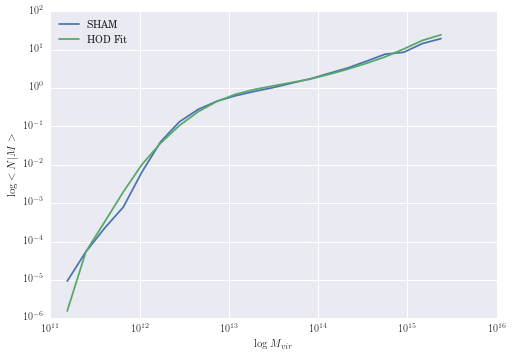

In [59]:
plt.plot(mass_bin_centers, cen_hod_sham+sat_hod_sham, label = 'SHAM')
plt.plot(mass_bin_centers, cen_hod_mock+sat_hod_mock, label = 'HOD Fit')
plt.legend(loc='best')
plt.xlabel(r"$\log{M_{vir}}$")
plt.ylabel(r"$\log{<N|M>}$")
plt.loglog()
plt.show();

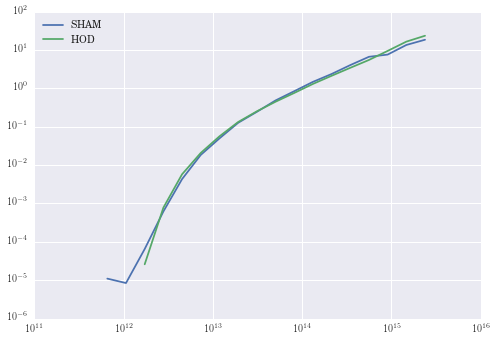

In [60]:
plt.plot(mass_bin_centers, sat_hod_sham, label = 'SHAM')
plt.plot(mass_bin_centers, sat_hod_mock, label = 'HOD')
plt.legend(loc='best')

plt.vlines(PMASS*min_ptcl,0, 100)
plt.loglog()
plt.show();

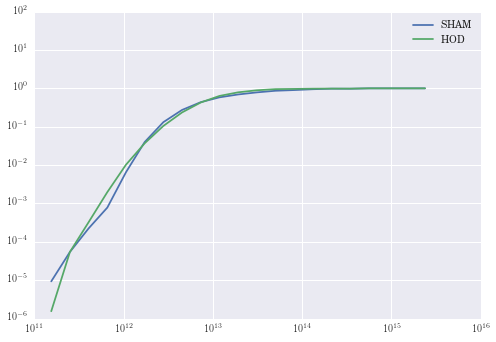

In [61]:
plt.plot(mass_bin_centers, cen_hod_sham, label = 'SHAM')
plt.plot(mass_bin_centers, cen_hod_mock, label = 'HOD')
plt.legend(loc='best')

plt.vlines(PMASS*min_ptcl,0, 100)
plt.loglog()
plt.show();

In [62]:
sham_nd = len(galaxy_catalog)/(cat.Lbox*0.7)**3
hod_nd = cat.calc_analytic_nd()

In [63]:
print sham_nd/hod_nd

1.00169080994


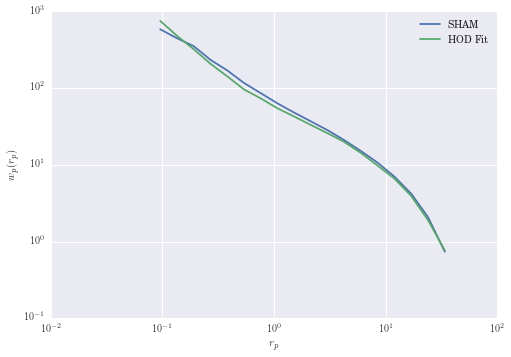

In [64]:
plt.plot(rpoints, wp_sham, label = 'SHAM')
plt.plot(rpoints, wp_hod, label = 'HOD Fit')
plt.loglog()
#plt.xscale('log')
#plt.ylim([-0.2, 3.5])
plt.legend(loc='best')
plt.xlabel(r"$r_p$")
plt.ylabel(r"$w_p(r_p)$")
plt.show()

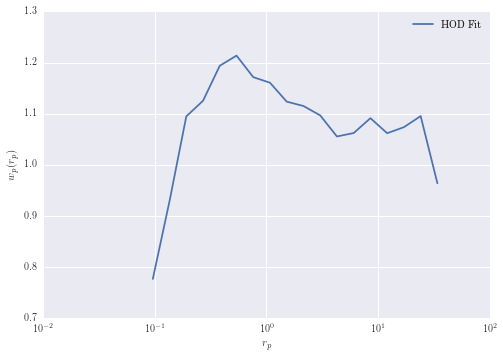

In [65]:
#plt.plot(rpoints, wp_sham, label = 'SHAM')
plt.plot(rpoints, wp_sham/wp_hod, label = 'HOD Fit')
plt.xscale('log')
#plt.xscale('log')
#plt.ylim([-0.2, 3.5])
plt.legend(loc='best')
plt.xlabel(r"$r_p$")
plt.ylabel(r"$w_p(r_p)$")
plt.show()

In [ ]:
wp_hod

In [ ]:
plt.figure(figsize=(10,8))

#plt.plot(rpoints, wp_sham/wp_sham, label = 'SHAM')
plt.plot(rpoints, wp_hod/wp_sham, label = 'HOD Fit')
plt.xscale('log')
plt.legend(loc='best',fontsize = 15)
plt.xlim([1e-1, 30e0]);
#plt.ylim([1,15000])
plt.xlabel(r'$r$',fontsize = 15)
plt.ylabel(r'$\xi(r)$',fontsize = 15)
plt.show()

In [ ]:
print wp_sham/wp_hod

In [ ]:
print wp_sham
print wp_hod

In [ ]:
from pearce.emulator import OriginalRecipe, ExtraCrispy

In [ ]:
training_dir = '/u/ki/swmclau2/des/PearceLHC_wp_z_sham_emulator_no_rsd/'

em_method = 'gp'
split_method = 'random'

load_fixed_params = {'z':0.0}

emu = ExtraCrispy(training_dir,10, 2, split_method, method=em_method, fixed_params=load_fixed_params)

In [ ]:
for n in names:
    print n, emu.get_param_bounds(n)